In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
import os
import keras as K
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL']= '2'

In [ ]:
# !gdown --id '1S9iwczSf6KL5jMSmU20SXKCSD3BUx4o_' --output level-6.csv #GMPR_genus
!gdown --id '1q0yp1iM66BKvqee46bOuSZYwl_SJCTp0' --output level-6.csv #GMPR_species

Downloading...
From: https://drive.google.com/uc?id=1q0yp1iM66BKvqee46bOuSZYwl_SJCTp0
To: /content/level-6.csv
100% 1.67M/1.67M [00:00<00:00, 61.1MB/s]


In [ ]:
train = pd.read_csv("level-6.csv")
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Columns: 1139 entries, index to Diagnosis
dtypes: float64(785), int64(352), object(2)
memory usage: 3.8+ MB


In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train["Diagnosis"] = labelencoder.fit_transform(train["Diagnosis"])
# test["Diagnosis"] = labelencoder.fit_transform(test["Diagnosis"])
# for i in range(len(train)):
#     if train["Diagnosis"][i] == 'Cancer':
#         train["Diagnosis"][i] = str(1)
#     else:
#         train["Diagnosis"][i] = str(0)
train

,index,Archaea.Euryarchaeota.Methanobacteria.Methanobacteriales.Methanobacteriaceae.Methanobrevibacter.__,Archaea.Euryarchaeota.Methanobacteria.Methanobacteriales.Methanobacteriaceae.Methanosphaera.__,Archaea.Euryarchaeota.Methanomicrobia.Methanosarcinales.Methanosarcinaceae.Methanococcoides.,Archaea.Thermoplasmatota.Thermoplasmata.Methanomassiliicoccales.Methanomassiliicoccaceae.Methanomassiliicoccus.__,Archaea.Thermoplasmatota.Thermoplasmata.Methanomassiliicoccales.Methanomethylophilaceae.Candidatus_Methanomethylophilus.__,Archaea.Thermoplasmatota.Thermoplasmata.Methanomassiliicoccales.Methanomethylophilaceae.uncultured.__,Bacteria.Acidobacteriota.Acidobacteriae.Acidobacteriales.Acidobacteriaceae_.Subgroup_1..Acidobacterium.uncultured_organism,Bacteria.Actinobacteria.Actinobacteria.Actinomycetales.Actinomycetaceae..__,Bacteria.Actinobacteria.Actinobacteria.Corynebacteriales.Corynebacteriaceae.Corynebacterium.,Bacteria.Actinobacteria.Actinobacteria.Propionibacteriales.Propionibacteriaceae.Propionibacterium.,Bacteria.Actinobacteria.Coriobacteriia.Coriobacteriales.Coriobacteriaceae.FCNB.PAC002389,Bacteria.Actinobacteria.Coriobacteriia.Coriobacteriales.Coriobacteriaceae.PAC002528.PAC002528,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Actinomyces.Actinomyces_graevenitzii,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Actinomyces.Winkia_neuii,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Actinomyces.__,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Actinomyces.human_gut_metagenome,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Arcanobacterium.Chlamydia_trachomatis,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Arcanobacterium.uncultured_bacterium,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.F0332.__,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Mobiluncus.__,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Trueperella.__,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Varibaculum.__,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.__.__,Bacteria.Actinobacteriota.Actinobacteria.Bifidobacteriales.Bifidobacteriaceae.Alloscardovia.uncultured_bacterium,Bacteria.Actinobacteriota.Actinobacteria.Bifidobacteriales.Bifidobacteriaceae.Bifidobacterium.Bifidobacterium_bifidum,Bacteria.Actinobacteriota.Actinobacteria.Bifidobacteriales.Bifidobacteriaceae.Bifidobacterium.__,Bacteria.Actinobacteriota.Actinobacteria.Bifidobacteriales.Bifidobacteriaceae.Scardovia.__,Bacteria.Actinobacteriota.Actinobacteria.Corynebacteriales.Corynebacteriaceae.Corynebacterium.Corynebacterium_durum,Bacteria.Actinobacteriota.Actinobacteria.Corynebacteriales.Corynebacteriaceae.Corynebacterium.Corynebacterium_sp._oral_taxon_B00,Bacteria.Actinobacteriota.Actinobacteria.Corynebacteriales.Corynebacteriaceae.Corynebacterium.__,Bacteria.Actinobacteriota.Actinobacteria.Corynebacteriales.Corynebacteriaceae.Lawsonella.__,Bacteria.Actinobacteriota.Actinobacteria.Corynebacteriales.Nocardiaceae.Rhodococcus.__,Bacteria.Actinobacteriota.Actinobacteria.Micrococcales.Micrococcaceae.Glutamicibacter.__,Bacteria.Actinobacteriota.Actinobacteria.Micrococcales.Micrococcaceae.Kocuria.Rothia_kristinae,Bacteria.Actinobacteriota.Actinobacteria.Micrococcales.Micrococcaceae.Kocuria.__,Bacteria.Actinobacteriota.Actinobacteria.Micrococcales.Micrococcaceae.Micrococcus.__,Bacteria.Actinobacteriota.Actinobacteria.Micrococcales.Micrococcaceae.Rothia.Rothia_dentocariosa,Bacteria.Actinobacteriota.Actinobacteria.Micrococcales.Micrococcaceae.Rothia.__,Bacteria.Actinobacteriota.Coriobacteriia.Coriobacteriales.Atopobiaceae.Atopobium.Atopobium_fossor,...,Bacteria.Synergistota.Synergistia.Synergistales.Synergistaceae.Cloacibacillus.__,Bacteria.Synergistota.Synergistia.Synergistales.Synergistaceae.Fretibacterium.Synergi

In [ ]:
not_select = ["index", "Diagnosis"]
train_select = train.drop(not_select,axis=1)
df_final_select = train_select

#Ph-CNN
##reference:
###https://github.com/dfioravanti/phylogenetic-cnn
###https://www.tensorflow.org/tutorials/images/cnn

##Import coordinate data

In [ ]:
# !gdown --id '1twQxfPShnt05CwJl8fY9Q9YxHnq0XNq_' --output ordinate.csv #GMPR
!gdown --id '1UHfMq8742mRthqrMSZKPYQmgEgt9Lu6q' --output ordinate.csv #GMPR
C = pd.read_csv("ordinate.csv")

Downloading...
From: https://drive.google.com/uc?id=1UHfMq8742mRthqrMSZKPYQmgEgt9Lu6q
To: /content/ordinate.csv
100% 2.44M/2.44M [00:00<00:00, 66.3MB/s]


In [ ]:
C.head()

,index,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,...,PC404,PC405,PC406,PC407,PC408,PC409,PC410,PC411,PC412,PC413,PC414,PC415,PC416,PC417,PC418,PC419,PC420,PC421,PC422,PC423,PC424,PC425,PC426,PC427,PC428,PC429,PC430,PC431,PC432,PC433,PC434,PC435,PC436,PC437,PC438,PC439,PC440,PC441,PC442,PC443
0,SRR7142497,4.229855,-4.254942,0.345110,-3.963664,3.667364,0.968674,-0.803691,0.794604,-0.800097,0.767724,0.273307,-0.130232,0.150557,-0.941687,0.546439,-0.371670,1.044222,-0.534215,1.750804,-2.403860,0.744974,-1.139921,0.205563,0.176865,-0.404877,0.537379,0.492370,-0.030189,0.078731,-0.246273,0.767984,-1.041187,0.006651,-0.056112,0.028761,-0.638613,0.060319,-0.248135,0.794203,...,0.192264,0.004944,-0.275617,-0.338475,-0.126746,-0.194400,0.592807,0.450992,-0.185481,-0.286988,-0.019091,-0.270954,-0.087459,0.353752,0.064662,-0.185859,-0.068106,-0.033487,-0.083203,-0.057830,0.551774,0.124533,0.324639,-0.255027,0.124808,0.144430,0.025621,-0.256309,0.208404,0.103510,-0.113679,0.270379,0.035533,-0.084434,0.013007,-0.059810,0.141388,-0.193480,0.036628,-3.100000e-15
1,SRR7142491,3.436372,-4.990336,1.196788,-3.236302,3.221191,1.165782,0.903154,-0.615400,-0.668225,0.507531,1.180718,-1.468391,0.604846,1.998030,0.834599,-0.076518,1.265629,0.631554,0.788584,0.393014,-0.432659,0.825055,-0.684302,0.016416,1.375310,-0.046511,-1.423450,-0.631098,-0.867497,-0.032333,-0.354277,-0.211756,1.123660,0.099142,-0.089320,0.688810,0.608131,0.522756,0.027627,...,-0.132801,0.031065,-0.092699,0.049693,-0.222077,0.045006,0.230464,-0.064256,-0.032367,-0.136095,0.007793,-0.072929,-0.080061,0.058331,0.164618,0.181445,0.129276,0.000861,0.021255,0.075102,0.029315,-0.027729,0.018687,-0.062044,0.101709,-0.113013,-0.073219,0.018710,0.032047,0.007863,-0.049545,0.029733,0.006903,0.041533,0.040952,-0.049054,-0.016591,0.004628,-0.000972,1.030000e-15
2,SRR7142505,0.623985,-3.806039,4.214450,-4.432911,2.466929,-2.020296,2.601054,-2.448016,-1.752305,-1.492455,2.170748,0.283147,1.447285,0.334838,-2.117070,-1.737978,1.422570,-2.025299,-0.643826,1.013342,0.914962,-0.370982,-1.117128,-2.457347,-0.348302,-0.542964,1.125019,-0.036893,0.316504,-3.233065,0.062078,1.741863,1.088514,1.657708,0.166321,-2.375377,-2.219776,-2.281334,-1.667937,...,-0.178916,0.521241,-0.017337,-0.151984,-0.086345,-0.274522,0.277664,0.192432,-0.281162,0.283528,0.183518,-0.052454,0.024772,-0.055139,0.180888,-0.117234,0.052358,-0.011029,0.059761,-0.019111,-0.248517,-0.087974,-0.001467,0.449439,0.007142,-0.033478,0.193854,-0.112748,-0.072833,0.214530,-0.114550,0.303329,0.107955,-0.147824,-0.165554,-0.081065,0.010017,0.071490,0.010401,1.130000e-15
3,SRR7142475,1.557159,-3.833913,0.681077,-4.936189,4.367942,0.124928,1.679421,-0.376460,-0.586308,0.784144,2.036901,-0.264819,-0.548796,1.854077,0.743498,0.160323,1.162912,-1.288848,-0.225003,-0.734080,0.907968,0.608835,-1.094460,-0.000641,0.907665,0.746052,-0.116061,0.526401,0.227828,-0.043473,-0.391439,-0.699071,1.152717,-0.674125,0.293208,0.860854,-2.054781,-0.389003,-0.036893,...,-0.142164,0.123844,-0.164294,-0.183028,-0.134157,0.259424,-0.150310,0.206474,0.099980,-0.112979,0.182069,-0.011586,-0.173116,0.111660,0.026373,0.031055,-0.053541,0.041982,-0.073630,0.229409,0.038160,0.157991,0.137734,0.180640,-0.104233,-0.040778,0.203575,0.034052,-0.002347,0.067370,0.049263,-0.013732,-0.074429,0.029977,-0.036538,0.079477,0.100943,-0.040612,0.026604,1.160000e-15
4,SRR7142509,7.086567,-3.929885,1.071474,-1.743327,0.351596,1.161513,0.276504,-0.049833,1.674486,-0.289491,-0.182035,-1.243916,0.846505,0.494756,1.141935,0.542689,1.116291,0.758026,0.312168,-0.282615,0.312811,0.069820,-0.485145,0.504761,-0.545770,-0.231721,-0.160244,-1.346870,0.119987,0.501573,0.001009,-0.107440,-0.080982,0.152925,-0.081967,0.353123,0.685340,0.796989,0.083359,...,0.039384,-0.362402,-0.038424,0.089494,-0.078297,-0.389616,0.444343,-0.146019,-0.112320,-0.250840,-0.3944

In [ ]:
not_select=['index','PC442','PC443']
C_final = C.drop(not_select,axis=1)
C_final.info()
C_final.head()
X_final = pd.concat([df_final_select, C_final], axis=1)
print(X_final.shape)
x = X_final
y = train['Diagnosis']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Columns: 441 entries, PC1 to PC441
dtypes: float64(441)
memory usage: 1.5 MB
(443, 1578)


In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.2,random_state=0)
train_x = train_x.values.reshape(354, 2, 263, 3)
train_x = train_x.reshape(354, 2, 263, 3)
test_x = test_x.values.reshape(89, 2, 263, 3)
test_x = test_x.reshape(89, 2, 263, 3)
train_x = tf.image.resize(train_x, (128, 128))
test_x = tf.image.resize(test_x, (128, 128))

(354, 1578)
(89, 1578)


## Model

In [ ]:
#group1
model = K.models.Sequential()
model.add(K.layers.Conv2D(3, (3, 3), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.Conv2D(20, (3, 3), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.MaxPooling2D((2, 2)))
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=1e-05, center=True, scale=True))
model.add(K.layers.Dense(12, activation= 'relu'))
model.add(K.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=1e-05, center=True, scale=True))
model.add(K.layers.Dropout(0.15))
model.add(K.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 3)       84        
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 20)      560       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 20)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 76880)             0         
                                                                 
 batch_normalization (BatchN  (None, 76880)            307520    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 12)                9

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
h2 = model.fit(train_x, train_y, epochs=20, batch_size=6, validation_data=(test_x, test_y), callbacks=[callback])

Epoch 1/20
59/59 [==============================] - 17s 27ms/step - loss: 0.7927 - accuracy: 0.5678 - val_loss: 0.6655 - val_accuracy: 0.5955
Epoch 2/20
59/59 [==============================] - 1s 15ms/step - loss: 0.5922 - accuracy: 0.6723 - val_loss: 0.6412 - val_accuracy: 0.7191
Epoch 3/20
59/59 [==============================] - 1s 15ms/step - loss: 0.4941 - accuracy: 0.7684 - val_loss: 0.6272 - val_accuracy: 0.6966
Epoch 4/20
59/59 [==============================] - 1s 18ms/step - loss: 0.4496 - accuracy: 0.7910 - val_loss: 0.6062 - val_accuracy: 0.6742
Epoch 5/20
59/59 [==============================] - 1s 14ms/step - loss: 0.3621 - accuracy: 0.8559 - val_loss: 0.5760 - val_accuracy: 0.6966
Epoch 6/20
59/59 [==============================] - 1s 12ms/step - loss: 0.3122 - accuracy: 0.8785 - val_loss: 0.5699 - val_accuracy: 0.7416
Epoch 7/20
59/59 [==============================] - 1s 11ms/step - loss: 0.3111 - accuracy: 0.8757 - val_loss: 0.5692 - val_accuracy: 0.6966
Epoch 8/20
5

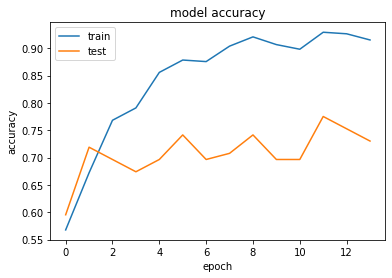

In [ ]:
# summarize history for accuracy
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

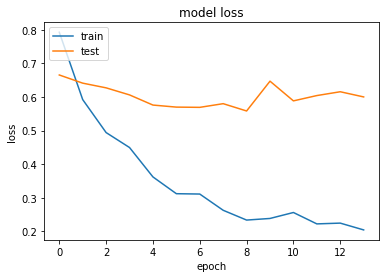

In [ ]:
# summarize history for loss
plt.plot(h2.history['loss'])
plt.plot(h2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(test_x)
# print(y_pred)
for i in range(len(y_pred)):
  if y_pred[i]<0.5:
    y_pred[i] = 0
  else:
    y_pred[i] = 1

precision =  <function precision_score at 0x7f3df7fa90e0>
recall =  [0.61764706 0.81818182]
auc_roc =  0.7179144385026738
f1_score =  <function f1_score at 0x7f3df7fa7d40>


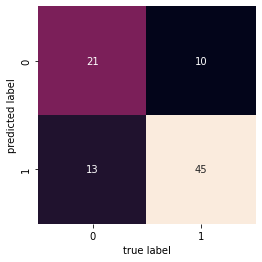

In [ ]:
mat = confusion_matrix(test_y, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
score_recall = recall_score(test_y, y_pred, average=None)
f1score = f1_score(test_y, y_pred, average="macro")
precisionscore = precision_score(test_y, y_pred, average=None)
auc_roc = roc_auc_score(test_y, y_pred)
print("precision = ",precision_score)
print("recall = ",score_recall)
print("auc_roc = ",auc_roc)
print("f1_score = ",f1_score)

with open('Ph-CNN_result.csv','w') as f:
    f.write('Precision_Normal,Precision_Cancer,Recall_Normal,Recall_Cancer,Auc_Score,F1_Score,')
    f.write('\n')
    f.write(str(precisionscore[0])+','+str(precisionscore[1])+','+str(score_recall[0])+','+str(score_recall[1])+','+str(auc_roc)+','+str(f1score))